In [159]:
import os
import glob
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime, date, time, timedelta

#for models
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.neighbors import KNeighborsRegressor

#for PCA & PLS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#for Data
import yfinance as yf

#for Data Distribution
from scipy.stats import kurtosis, skew, shapiro
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
import seaborn as sns


DOWNLOAD DATA

In [160]:
# Fetch historical data for the S&P 500
sp500_data = yf.download('^GSPC', start='2002-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [161]:
print(sp500_data.head())
print(f'\n\n Samples of S&P 500:{len(sp500_data)}') # Print the first few rows of the data

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2002-01-02  1148.079956  1154.670044  1136.229980  1154.670044  1154.670044   
2002-01-03  1154.670044  1165.270020  1154.010010  1165.270020  1165.270020   
2002-01-04  1165.270020  1176.550049  1163.420044  1172.510010  1172.510010   
2002-01-07  1172.510010  1176.969971  1163.550049  1164.890015  1164.890015   
2002-01-08  1164.890015  1167.599976  1157.459961  1160.709961  1160.709961   

                Volume  
Date                    
2002-01-02  1171000000  
2002-01-03  1398900000  
2002-01-04  1513000000  
2002-01-07  1308300000  
2002-01-08  1258800000  


 Samples of S&P 500:5537


Check NA values

In [162]:
# Check for NaN values in the data
nan_values_df = sp500_data.isna().any()

print("NaN values in DataFrame:")
print(nan_values_df)

NaN values in DataFrame:
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


Calculate Technical Indicators

In [163]:
#Simple Moving Average:
#returns the dataframe with additional coumn of simple moving average
def calculate_sma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Simple Moving Average (SMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate SMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with SMA column added.
    """
    # Calculate SMA
    sma = df[column].rolling(window=window_size, min_periods=1).mean()
    
    # Create a DataFrame to store SMA
    df['SMA'] = sma
    df['SMA_signal'] = df['Close'] - df['SMA']
    return df

In [164]:
#Weighted Moving Average
def calculate_wma(df: pd.DataFrame, column: str = 'Adj Close', window_size: int = 15) -> pd.DataFrame:
    """
    Calculate the Weighted Moving Average (WMA) for a given column in a DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing the financial data.
        column (str): Name of the column for which to calculate WMA. Default is 'close'.
        window_size (int): Size of the moving window. Default is 15.

    Returns:
        pd.DataFrame: DataFrame with WMA and WMA signal columns added.
    """
    # Generate the weights
    weights = np.arange(1, window_size + 1)
    data = df[column]
    
    # Calculate the WMA using convolution
    wma = data.rolling(window=window_size).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)
    
    # Create a DataFrame to store WMA
    df['WMA'] = wma
    
    # Add WMA signal column
    df['WMA_signal'] = df[column] - wma

    
    return df

In [165]:
#MACD
def calculate_macd(df: pd.DataFrame, short_window:int=12, long_window:int=26,
                    signal_window:int=9, column: str = 'Adj Close') -> pd.DataFrame:
    """
    Calculate the Moving Average Convergence Divergence (MACD) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        short_window (int): The short-term window size for the short EMA.
        long_window (int): The long-term window size for the long EMA.
        signal_window (int): The window size for the signal line EMA.

    Returns:
        DataFrame: DataFrame with additional columns for MACD and signal line.
    """
    # Calculate short-term EMA
    short_ema = df[column].ewm(span=short_window, min_periods=1, adjust=False).mean()
    
    # Calculate long-term EMA
    long_ema = df[column].ewm(span=long_window, min_periods=1, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = short_ema - long_ema
    
    # Calculate signal line
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    
    # Store MACD and signal line in the DataFrame
    df['MACD'] = macd_line
    df['Signal Line'] = signal_line
    df['macd_signal'] = macd_line - signal_line
    return df

In [166]:
#Stochastic_oscillator
def calculate_stochastic_oscillator(df, k_fast_period=14, k_slow_period=3, 
                                    d_slow_period=3, column: str = 'Adj Close'):
    """
    Calculate the Stochastic Oscillator and its corresponding moving averages (K and D lines).

    Parameters:
        df (DataFrame): DataFrame containing the data.
        k_fast_period (int): The period for the fast %K line.
        k_slow_period (int): The period for the slow %K line.
        d_slow_period (int): The period for the slow %D line.

    Returns:
        DataFrame: DataFrame with additional columns for %K_fast, %K_slow, %D_fast, and %D_slow.
    """
    # Calculate highest high and lowest low over the period
    HH = df['High'].rolling(window=k_fast_period).max()
    LL = df['Low'].rolling(window=k_fast_period).min()

    # Calculate %K_fast
    df['%K_fast'] = ((df[column] - LL) / 
                     (HH - LL)) * 100
    
    # Calculate %K_slow (smoothed %K_fast)
    df['%K_slow'] = df['%K_fast'].rolling(window=k_slow_period).mean()
    
    # Calculate %D_fast (3-day SMA of %K_slow)
    df['%D_fast'] = df['%K_slow'].rolling(window=d_slow_period).mean()
    
    # Calculate %D_slow (3-day SMA of %D_fast)
    df['%D_slow'] = df['%D_fast'].rolling(window=d_slow_period).mean()
    
    return df

In [167]:
#RSI
def calculate_rsi(df, window_size=14, column: str = 'Adj Close'):
    """
    Calculate the Relative Strength Index (RSI) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating RSI.

    Returns:
        DataFrame: DataFrame with an additional column for RSI.
    """
    # Calculate price changes
    delta = df[column].diff()
    
    # Define up and down moves
    gain = (delta.where(delta > 0, 0)).rolling(window=window_size).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_size).mean()
    
    # Calculate the relative strength (RS)
    rs = gain / loss
    
    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    
    # Store RSI in the DataFrame
    df['RSI'] = rsi
    
    return df

In [168]:
#WPR
def calculate_williams_percent_r(df, window=14, column: str = 'Adj Close'):
    """
    Calculate the Williams %R (WPR) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for calculating WPR.

    Returns:
        DataFrame: DataFrame with an additional column for WPR.
    """
    # Calculate highest high and lowest low over the window
    highest_high = df['High'].rolling(window=window).max()
    lowest_low = df['Low'].rolling(window=window).min()
    
    # Calculate Williams %R
    wpr = ((highest_high - df[column]) / (highest_high - lowest_low)) * -100
    
    # Store WPR in the DataFrame
    df['WPR'] = wpr
    
    return df

In [169]:
#Bollinger Bands
def calculate_bollinger_bands(df, window=20, num_std_dev=2, column: str = 'Adj Close'):
    """
    Calculate Bollinger Bands for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        window (int): The window size for the moving average.
        num_std_dev (int): The number of standard deviations for the bands.

    Returns:
        DataFrame: DataFrame with additional columns for Bollinger Bands.
    """
    # Calculate rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=window).mean()
    rolling_std = df[column].rolling(window=window).std()
    
    # Calculate upper and lower bands
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    
    # Store Bollinger Bands in the DataFrame
    df['Bollinger Upper'] = upper_band
    df['Bollinger Lower'] = lower_band
    df['Bollinger Diff'] = upper_band - lower_band
    
    return df

In [170]:
#On-Balance Volume (OBV)
def calculate_obv(df, column: str = 'Adj Close'):
    """
    Calculate On-Balance Volume (OBV) for a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.

    Returns:
        DataFrame: DataFrame with additional column for OBV.
    """
    obv_values = []
    prev_obv = 0

    for i in range(1, len(df)):
        if df[column].iloc[i] > df[column].iloc[i - 1]:
            obv = prev_obv + df['Volume'].iloc[i]
        elif df[column].iloc[i] < df[column].iloc[i - 1]:
            obv = prev_obv - df['Volume'].iloc[i]
        else:
            obv = prev_obv

        obv_values.append(obv)
        prev_obv = obv

    # Add initial OBV value as 0
    obv_values = [0] + obv_values

    # Store OBV in the DataFrame
    df['OBV'] = obv_values

    return df

In [171]:
#Average True Range (ATR)
def calculate_atr(df, period=14):
    """
    Calculate the Average True Range (ATR) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 
        and 'Close' columns representing high, low, and closing prices respectively.
        period (int): Number of periods for which to calculate the ATR (default is 14).

    Returns:
        DataFrame: DataFrame with 'ATR' column containing the calculated ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    
    # True Range (TR) calculation
    df['TR'] = df[['High', 'Low', 'Adj Close']].apply(lambda row: max(row['High'] 
    - row['Low'], abs(row['High'] - row['Adj Close']), abs(row['Low'] - row['Adj Close'])), axis=1)
    
    # ATR calculation
    df['ATR'] = df['TR'].rolling(period).mean()
    
    # Drop the TR column if not needed
    df.drop('TR', axis=1, inplace=True)
    
    return df

In [172]:
#rice Rate of Change (ROC)
def calculate_roc(df, n_periods=12, column='Adj Close'):
    """
    Calculate the Price Rate of Change (ROC) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'Adj Close' column representing 
        closing prices. n_periods (int): Number of periods for which to calculate the ROC. 
        # It can be anything such as 12, 25, or 200. Short-term trader traders typically use a
        smaller number while longer-term investors use a larger number.

    Returns:
        DataFrame: DataFrame with 'ROC' column containing the calculated ROC values.
    """
    close_prices = df[column]
    close_prices_shifted = close_prices.shift(n_periods)
    
    roc = ((close_prices - close_prices_shifted) / close_prices_shifted) * 100
    
    df['ROC'] = roc
    return df

In [173]:
#Money Flow Index - MFI
def calculate_mfi(df, period=14):
    """
    Calculate the Money Flow Index (MFI) of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        period (int): Number of periods for which to calculate the MFI (default is 14).

    Returns:
        DataFrame: DataFrame with 'MFI' column containing the calculated MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Typical Price calculation
    tp = (high + low + close) / 3
    
    # Raw Money Flow calculation
    mf = tp * volume
    
    # Determine whether the typical price is higher or lower than the previous period
    tp_shifted = tp.shift(1)
    positive_flow = (tp > tp_shifted)
    negative_flow = (tp < tp_shifted)
    
    # Calculate positive and negative money flow
    positive_mf = positive_flow * mf
    negative_mf = negative_flow * mf
    
    # Calculate the Money Flow Ratio (MFR)
    mfr = positive_mf.rolling(window=period).sum() / negative_mf.rolling(window=period).sum()
    
    # Calculate the Money Flow Index (MFI)
    mfi = 100 - (100 / (1 + mfr))
    
    df['MFI'] = mfi
    
    return df

In [174]:
def calculate_chaikin_oscillator(df, short_period=3, long_period=10):
    """
    Calculate the Chaikin Oscillator of a stock dataset.

    Parameters:
        df (DataFrame): DataFrame containing stock data, with 'High', 'Low', 'Adj Close', and 'Volume' columns representing high, low, closing prices, and volume respectively.
        short_period (int): Number of periods for the short EMA (default is 3).
        long_period (int): Number of periods for the long EMA (default is 10).

    Returns:
        DataFrame: DataFrame with 'Chaikin_Oscillator' column containing the calculated Chaikin Oscillator values.
    """
    high = df['High']
    low = df['Low']
    close = df['Adj Close']
    volume = df['Volume']
    
    # Money Flow Multiplier calculation
    mfm = ((close - low) - (high - close)) / (high - low)
    
    # Money Flow Volume calculation
    mfv = mfm * volume
    
    # Accumulation/Distribution Line (ADL) calculation
    adl = mfv.cumsum()
    
    # Calculate the EMA for ADL
    ema_short = adl.ewm(span=short_period, min_periods=short_period, adjust=False).mean()
    ema_long = adl.ewm(span=long_period, min_periods=long_period, adjust=False).mean()
    
    # Calculate the Chaikin Oscillator
    chaikin_oscillator = ema_short - ema_long
    
    df['Chaikin_Oscillator'] = chaikin_oscillator
    
    return df

In [175]:
#Bulid the technical indicators: features
def technical_indicators(df):
    df = calculate_sma(df)
    df = calculate_wma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_stochastic_oscillator(df)
    df = calculate_bollinger_bands(df)
    df = calculate_williams_percent_r(df)
    df = calculate_obv(df)
    df = calculate_roc(df)
    df = calculate_atr(df)
    df = calculate_mfi(df)
    df = calculate_chaikin_oscillator(df)
    return df 

Avoid look ahead bias

In [176]:
# All analyzed technical indicators are lagged by one period before being used as predictors for 
# returns in the models in order to avoid the so-called look ahead bias involving making decisions 
# in the same period for which the given signal was generated.
def lag_technical_indicators(df):
    """
    Lag all columns in a DataFrame by one period.

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns lagged by one period.
    """
    # Lag all columns by one period
    df_lagged = df.shift()
    
    return df_lagged

Transformation Function: [-1,1]

In [177]:
# Transformation Function
# Technical analysis indicators need to be rescaled before being fed to the models.
# The process is conducted using a version of min-max normalization technique which produces outputs in range from ‐1 to 1.
# This technique was chosen for two reasons: it is intuitive as the machine learning models produce output 
# variable that is also ranging from ‐1 to 1 and because it causes the input data to be more comparable. 
# X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

def feature_transform(df):
    """
    Transform all columns in the DataFrame as the following formula
    X'(t) = (X(t) - min(x)) / (max(x) - min(x))*2 -1

    Parameters:
        df (DataFrame): DataFrame containing the calculated technical indicators.

    Returns:
        DataFrame: DataFrame with all columns transformed.
    """
    max_x = df.max()
    min_x = df.min()

    df_transformed = (df - min_x) / (max_x - min_x) * 2 - 1

    return df_transformed

Calculate Return

In [178]:
#Log_return:
def calculate_log_return(df, column='Adj Close'):
    """
    Calculate log returns from adjusted close prices.

    Parameters:
        df (DataFrame): DataFrame containing adjusted close prices.
        column (str): Name of the column containing adjusted close prices.

    Returns:
        DataFrame: DataFrame containing log returns.
    """
    # Shift adjusted close prices by one day to get t-1 prices
    previous_adj_close = df[column].shift(1)
    
    # Calculate log returns
    log_returns = np.log(df[column] / previous_adj_close)
    # Concatenate log returns with the original DataFrame
    df['log_return'] = log_returns  
    
    return df

In [179]:
def calculate_log_returns_per(df, column='Adj Close'):
    """
    Calculate logarithmic returns for adjusted closing prices.
    
    Parameters:
        df (DataFrame): DataFrame containing adjusted closing prices.
        column_name (str): Name of the column containing adjusted closing prices.
        
    Returns:
        log_returns (Series): Series containing logarithmic returns.
    """
    # Calculate the percentage change in adjusted closing prices
    returns = df[column].pct_change()
    
    # Calculate logarithmic returns
    log_returns = np.log(1 + returns)
    df['log_return_per'] = log_returns  

    return df

In [180]:
def calculate_discrete_returns(df, column='Adj Close'):
    """
    Calculate discrete returns for a given column in a DataFrame.
    
    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column for which to calculate discrete returns.
        
    Returns:
        discrete_returns (Series): Series containing discrete returns.
    """
    # Calculate the difference between consecutive values
    differences = df[column].diff()
    
    # Calculate discrete returns
    discrete_returns = differences / df[column].shift(1)
    df['discrete_return'] = discrete_returns  
    
    return df

Walk Forward

In [181]:
#truncate the dataframe from the biggining so the walk forward splits will continue untill the last date
def truncate_before_wf(df, in_sample_size, out_sample_size):
    drop_index = (len(df) - in_sample_size) % out_sample_size
    return (df.iloc[drop_index:, :])

In [182]:
# Research employed dynamic estimation windows which means that the underlying parameters of the models 
# were periodically recalibrated to reflect current market behaviors. Observations from the beginning 
# of the available period were initially trimmed in order for the overall number of observations for
# each index to be easily divisible into equal subsets. Calibration of models’ parameters was conducted 
# on 200 trading day window (in-sample) and then model predictions were applied onto next 20 trading day
# window (out-of-sample). For each subsequent dynamic window iteration, in-sample and out-of-sample moved 
# by 20 trading days. 

def walk_forward_validation(df, in_sample_size, out_sample_size):
    """
    Perform walk-forward validation on a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        in_sample_size (int): Number of periods to use for in-sample data.
        out_sample_size (int): Number of periods to use for out-of-sample data.

    Returns:
        Tuple: Tuple containing lists of in-sample and out-of-sample data.
    """
    total_rows = len(df)
    n_subsets = (total_rows - in_sample_size) // out_sample_size
    splits = []
        
    for i in range(n_subsets):
        start_index = i * out_sample_size
        end_index = start_index + in_sample_size + out_sample_size
        
        if end_index > total_rows:
            break
        
        in_sample = df.iloc[start_index : start_index + in_sample_size]
        out_of_sample = df.iloc[start_index + in_sample_size : end_index]
        
        splits.append((in_sample, out_of_sample))
    return (splits)

Data Analysis Tools

In [183]:
# Compute the correlation coefficients between each feature and the return & print it

def correlation(df, target_name):

    correlation_with_target = np.abs(df.corrwith(df[target_name]))

    # Display the correlation coefficients
    print("Correlation with Log return:")
    print(correlation_with_target.sort_values(ascending=False))
    correlation_with_target.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation', )

In [184]:
#Thus far, we've only used a simple correlation statistic across the full time period. 
#This is a good place to start but, is a dangerous place to stop. Financial time series data suffers
# from non-stationarity and regime change, so a relationship which on average has existed may have been 
#wildly unstable over time.

#To check, we'll plot the rolling correlation of these selected features.

# Compute the rolling correlation for each pair of selected features
def rolling_correlation(df, target_name, window_size = 200):

    correlation_with_target_200 = df.rolling(window=window_size).corr(df[target_name])
    # Create traces for each feature
    traces = []
    for feature in df.columns:
        trace = go.Scatter(
            x=correlation_with_target_200.index,
            y=correlation_with_target_200[feature],
            mode='lines',
            name=feature
        )
        traces.append(trace)

    # Create layout for the plot
        layout = go.Layout(
        title='Rolling Correlation of Features with Log Return',
        xaxis=dict(title='Index'),
        yaxis=dict(title='Rolling Correlation with Log Return'),
        hovermode='closest',
        autosize=True
    )

    # Create figure object
    fig = go.Figure(data=traces, layout=layout)

    # Show plot
    fig.show()

In [185]:
def features_paiplot(df):
    pairplot = sns.pairplot(df, height=1.5)

    # Set the title
    pairplot.figure.suptitle('Pairplot of features', y=1.02)

    # Show the plot
    plt.show()

In [186]:
#check distribution 
def check_distribution(df, column_name='Adj Close'):
    """
    Check the distribution of a column in a DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        column_name (str): Name of the column to check the distribution for (default is 'Adj Close').

    Returns:
        None (displays descriptive statistics and visualizations)
    """
    # Descriptive statistics
    print("Descriptive Statistics:")
    print(df[column_name].describe())

    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column_name], kde=True)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.show()

In [187]:
def check_distribution_type(column_data, alpha=0.05):
    """
    Check if the given column data is normally distributed or has positive kurtosis.

    Parameters:
    - column_data: Pandas Series containing the column data to be checked.
    - alpha: Significance level for hypothesis testing (default is 0.05).

    Returns:
    - result: A string describing the distribution based on the tests performed.
    """
    # Calculate kurtosis and skewness
    kurt = kurtosis(column_data)
    skewness = skew(column_data)
    
    # Perform Shapiro-Wilk test for normality
    stat_shapiro, p_value_shapiro = shapiro(column_data)
    
    # Plot histogram and Q-Q plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=20, density=True, color='skyblue', edgecolor='black')
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    plt.scatter(*np.percentile(column_data, [25, 75]), color='r', marker='o')
    plt.boxplot(column_data, vert=False)
    plt.title('Boxplot')
    plt.show()
    
    # Print summary statistics
    print("Summary Statistics:")
    print(f"Kurtosis: {kurt:.4f}")
    print(f"Skewness: {skewness:.4f}")
    print(f"Shapiro-Wilk test p-value: {p_value_shapiro:.4f}")
    
    # Determine distribution based on tests
    if p_value_shapiro > alpha and kurt < 0:
        result = "Normally Distributed"
    elif p_value_shapiro > alpha and kurt > 0:
        result = "Positive Kurtosis"
    else:
        result = "Unknown"
    
    return result

In [188]:
def check_distribution_k(data):
    # Calculate kurtosis
    kurt = kurtosis(data, fisher=False)
    
    # Perform Shapiro-Wilk test for normality
    _, p_value = shapiro(data)
    
    # Check if kurtosis is positive and p-value of Shapiro-Wilk test is greater than 0.05
    if kurt > 0 and p_value > 0.05:
        return "Positively kurtotic"
    else:
        return "Normally distributed"

In [189]:
def count_outliers_iqr_df(df, k=1.5):
    """
    Count the number of outliers in each column of the DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
    - df: The input DataFrame.
    - k: The multiplier for the IQR. Typically set to 1.5 to 3.
    
    Returns:
    - A dictionary where keys are column names and values are the number of outliers detected in each column.
    """
    outliers_counts = {}
    for col in df.columns:
        data = df[col]
        quartile_1, quartile_3 = np.percentile(data, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (k * iqr)
        upper_bound = quartile_3 + (k * iqr)
        outliers = (data < lower_bound) | (data > upper_bound)
        outliers_counts[col] = np.sum(outliers)
    return outliers_counts


In [190]:
def is_normal(df, alpha=0.05):
    """
    Test if the data is normally distributed using Z-score.
    
    Parameters:
    - data: The input data array.
    - alpha: The significance level for the test.
    
    Returns:
    - True if the data is normally distributed, False otherwise.
    """
    normal_col = {}
    for col in df.columns:
        data = df[col]
        z_score, p_value = stats.normaltest(data)
        normal_col[col] = p_value > alpha
    return normal_col

Data Cleaning

In [191]:
#Truncate NaN Data
def drop_nan(df):
    # Remove rows with NaN values
    cleaned_df = df.dropna()

    return cleaned_df

PCA

In [192]:
def perform_pca(df, num_components=11):
    """
    Perform Principal Component Analysis (PCA) on the given DataFrame.

    Parameters:
        df (DataFrame): DataFrame containing the data.
        num_components (int): Number of principal components to retain (default is 2).

    Returns:
        pca_df (DataFrame): DataFrame containing the principal components.
        explained_variance_ratio (array): Array containing the explained variance ratio of each principal component.
        principal_components (array): Array containing the principal components.
    """
    # Step 1: Preprocess the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # Step 2: Perform PCA
    pca = PCA(n_components=num_components)
    pca_data = pca.fit_transform(scaled_data)

    # Step 3: Visualize the results
    pca_df = pd.DataFrame(data=pca_data, columns=[f'PC{i+1}' for i in range(num_components)])

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
    plt.title('Principal Component Analysis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

    # Step 4: Analyze the explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:")
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"PC{i + 1}: {ratio:.2f}")

    # Optionally, you can also access the principal components themselves
    principal_components = pca.components_
    
    # Get the loadings of each principal component
    loadings = pca.components_

    # Create a DataFrame to hold the loadings
    loadings_df = pd.DataFrame(loadings, columns=df.columns)  # Assuming df is your DataFrame

    # Print the top n indicators with the highest loadings for each principal component
    num_top_indicators = num_components  
    for i in range(num_components):
        print(f"Principal Component {i + 1}:")
        top_indicators = loadings_df.iloc[i].nlargest(num_top_indicators)
        print(top_indicators)

    # Compute cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Plot explained variance ratio vs. number of components
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA: Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return pca_df, explained_variance_ratio, principal_components


In [193]:
def perform_pls(df_X, y, num_components=13, n_top_indicators=3, min_c=1, max_c=13):
    """
    Perform Partial Least Squares (PLS) regression on the given DataFrame.

    Parameters:
        df_X (DataFrame): DataFrame containing the features.
        y (array-like): Array containing the target values.
        num_components (int): Number of components for PLS regression (default is 2).

    Returns:
        X_pls (array): Lower-dimensional representation of the data obtained by PLS.
    """
    # Initialize PLS regression with the desired number of components
    pls = PLSRegression(n_components=num_components)

    # Standardize the features by scaling them to have mean 0 and standard deviation 1
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_X)

    # Fit PLS regression model to the scaled data
    pls.fit(X_scaled, y)

    # Transform the data to the lower-dimensional space
    X_pls = pls.transform(X_scaled)

    # Get the loadings of each component
    loadings = pls.x_loadings_

    # Create a DataFrame to hold the loadings
    loadings_df = pd.DataFrame(loadings, columns=df_X.columns)

    # Print the top n indicators with the highest loadings for each component
    num_top_indicators = n_top_indicators  # Adjust this value based on how many top indicators you want to show
    for i in range(num_components):
        print(f"Component {i + 1}:")
        top_indicators = loadings_df.iloc[:, i].nlargest(num_top_indicators)
        print(top_indicators)

    # Initialize PLS regression model with a range of possible numbers of components
    min_components = min_c
    max_components = max_c
    components_range = range(min_components, max_components + 1)
    pls_models = [PLSRegression(n_components=n) for n in components_range]

    # Perform time series cross-validation for each number of components
    tscv = TimeSeriesSplit(n_splits=255)  # Adjust the number of splits as needed
    cv_scores = []
    for model in pls_models:
        scores = cross_val_score(model, df_X, y, cv=tscv, scoring='neg_mean_squared_error')  # Adjust scoring based on your task
        cv_scores.append(-scores.mean())  # Convert to positive mean squared error

    # Find the optimal number of components based on cross-validation scores
    optimal_components = components_range[np.argmin(cv_scores)]
    print("Optimal Number of Components:", optimal_components)
    return X_pls

Models Evaluation

In [194]:
def calculate_mape(actual, predicted):
    """
    Calculate Mean Absolute Percentage Error (MAPE)
    
    Args:
    actual: array-like, actual values
    predicted: array-like, predicted values
    
    Returns:
    mape: float, MAPE value
    """
    # Ensure both actual and predicted arrays have the same length
    if len(actual) != len(predicted):
        raise ValueError("Length of actual and predicted arrays must be the same.")
    

    # Calculate absolute percentage error for each observation
    abs_percentage_error = np.abs((actual - predicted) / np.maximum(np.abs(actual), 1e-10))
    
    # Calculate mean of absolute percentage errors
    mape = np.mean(abs_percentage_error) * 100
    
    return mape

Data Processing - First Step

In [195]:
#Copy Data & add Technical Indicators
sp500 = sp500_data.copy()
sp500 = technical_indicators(sp500)

In [196]:

#lagging technical indicators to avoid look_ahead bias
#sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(lag_technical_indicators, axis=0)

In [197]:
#transform features
sp500.iloc[:, 6:] = sp500.iloc[:, 6:].apply(feature_transform, axis=0)

C:\Users\Nagham\AppData\Local\Temp\ipykernel_6828\3326783675.py:2: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Date
2002-01-02   -0.934138
2002-01-03   -0.932189
2002-01-04   -0.930082
2002-01-07   -0.931904
2002-01-08   -0.933658
                ...   
2023-12-22    0.859675
2023-12-26    0.863177
2023-12-27    0.867006
2023-12-28    0.870766
2023-12-29    0.866411
Name: OBV, Length: 5537, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [198]:
#Add the Returns:
sp500 = calculate_log_return(sp500)
sp500 = calculate_discrete_returns(sp500)
sp500 = calculate_log_returns_per(sp500)

Feature Importance Analysis

In [ ]:
#look at the correlated data in order to select feature:

#correlation before choosing features
#correlation(sp500, 'log_return')
#rolling_correlation(sp500, 'log_return')

# Step 1: Take the most strongly correlated feature and add it to our list of selected features. 
# Step 2: Take the second correlated feature and check to see if it's closely correlated 
# (neighboring in the clustermap) to any features already chosen.
# If no, add to the list. If yes, discard. 
# Step 3: Repeat this process until either (1) we've reached the target feature count, or (2) we've run out strongly correlated features.

Chosen Features:
WMA_signal, macd_signal, RSI, %K_fast, %D_fast, %D_slow, Bollinger Diff, WPR, OBV, ROC, ATR, MFI,
Chaikin_Oscillator'

In [ ]:
outliers_counts = count_outliers_iqr_df(sp500)
print("Number of outliers in each column:")
print(outliers_counts)

In [ ]:
print("Is data normal?", is_normal(sp500))

Start here for each model

In [ ]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [ ]:
#look at the correlated data after feature selection:
#features_paiplot(sp500_d)
#correlation(sp500_d, 'log_return')
#rolling_correlation(sp500, 'log_return')


In [ ]:
#perform_pca(sp500_d.iloc[:,:-1])
#perform_pls(sp500_d.iloc[:,:-1], sp500_d.iloc[:,-1])
#check_distribution(sp500_d, 'log_return')
#check_distribution_type(sp500_d['log_return'])
#K = check_distribution_k(sp500_d['log_return'])
#print(K)

In the context of regression tasks like this one (since SVR is a Support Vector Machine for regression),
where the target variable is continuous (e.g., log returns), a model score less than 0 typically indicates 
that the model is performing poorly and making predictions that are worse than simply using the mean or another
basic statistical measure as the prediction for all samples.

Arima Model

In [ ]:
#Arima model
# Fetch historical data for the S&P 500
data = sp500.copy()
data = drop_nan(data)
data = data.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [ ]:
# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(data['log_return'], seasonal=False, trace=True)
print(model.summary())

The best Params for Arima (0,0,1)

Apply Arima

The data Splitted 80% - 20% - Walk Forward on test (the predictions added to the train)

In [ ]:
dataset_ex_df = data['log_return'].dropna()
# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [ ]:
#Evaluate
mae = mean_absolute_error(test,predictions)
mse = mean_squared_error(test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test,predictions)
mape = mean_absolute_percentage_error(test,predictions)
# Visualize predictions vs. actual values
plt.scatter(test,predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

print(f'Mean Absolute Error: {mae}\nMean Squared Error: {mse}\nRoot Mean Squared Error: {rmse}\nR-squared: {r2}')
print("Mean Absolute Percentage Error (MAPE):", mape)

In [ ]:
# Plotting
# Create traces
trace1 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=test, mode='lines', name='Adjusted Close')
trace2 = go.Scatter(x=dataset_ex_df.iloc[size:].index, y=predictions, mode='lines', name='Predections')

# Create figure
fig = go.Figure()

# Add traces to figure
fig.add_trace(trace1)
fig.add_trace(trace2)

# Update layout
fig.update_layout(title='Plot of Adjuste Close Vs. Cleaned trend Data over Time',
                  xaxis_title='Time',
                  yaxis_title='USD',
                  hovermode='x unified')

# Show plot
fig.show()

KNN Model

In [ ]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [ ]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)

In [ ]:

class KNNRegressor:
    def __init__(self, k=5):
        self.k = k
        self.oKNNreg = KNeighborsRegressor(n_neighbors=k)

    def fit(self, dfX: pd.DataFrame, vY: pd.Series):
        self.oKNNreg.fit(dfX, vY) 

    def predict(self, dfX: pd.DataFrame):
        y_pred = self.oKNNreg.predict(dfX)
        return y_pred

    def score(self, dfX: pd.DataFrame, vY: pd.Series):
        R2 = self.oKNNreg.score(dfX, vY)
        return R2
    
    def train(self, splits, col_drop):
        predictions = []
        evaluations = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.oKNNreg.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            y_test = out_of_sample[col_drop]
            predection = self.oKNNreg.predict(X_test)
            predictions.extend(predection)
            evaluations.extend(self.evaluate(y_test, predection))  #Append evaluation results as a single list
        return (predictions, evaluations)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)


In [ ]:
# Example usage:
# Instantiate LinearSVRTrainer
model = KNNRegressor()

# Train the model
predictions, eval = model.train(splits,'log_return')

#rearrange the evaluations from each iteration
eval = [eval[i:i+5] for i in range(0, len(eval), 5)]
c_names = ['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']
eval = pd.DataFrame(eval, columns=c_names)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = len(sp500_d)-len(predictions)

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections_LinearSVM'] = predictions

# Instantiate LinearSVREvaluator
evaluation_results = model.evaluate(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections_LinearSVM'] )

# Print evaluation results
print(f"Mean Absolute Error:{evaluation_results[0]}")
print(f"Mean Squared Error:{evaluation_results[1]}")
print(f"Root Mean Squared Error:{evaluation_results[2]}")
print(f"R2:{evaluation_results[3]}")
print(f"Mean Absolute Percentage Error:{evaluation_results[4]}")

In [ ]:
#Plot the evaluations for each iteration of the WF
for column in eval.columns:
    plt.figure()  # Create a new figure for each plot
    plt.plot(eval.index, eval[column], label=column)  # Plot the column
    plt.xlabel('Index of Rows')
    plt.ylabel('Values')
    plt.title(f'Plot of {column}')  # Add title with column name
    plt.legend()  # Show legend
    plt.show()  # Show the plot

In [ ]:
# Visualize predictions vs. actual values
plt.scatter(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections_LinearSVM'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

In [ ]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'Predections_LinearSVM'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='KNN K=5 - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()


Class for all models

In [199]:
class TimeSeriesModels:
    def __init__(self, k=5, svr_kernel='rbf', C=1.0, gamma=0.1, degree=3, rf_n_estimators=100, rf_max_features=4, 
                 rf_criterion = 'squared_error', gbm_n_estimators=100, gbm_criterion='squared_error',
                 gbm_loss='squared_error', gbm_n_features='sqrt'):

        self.k = k
        self.svr_kernel = svr_kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.rf_n_estimators = rf_n_estimators
        self.rf_max_features = rf_max_features
        self.rf_criterion = rf_criterion
        self.gbm_n_estimators = gbm_n_estimators
        self.gbm_criterion = gbm_criterion
        self.gbm_loss = gbm_loss
        self.gbm_n_features = gbm_n_features

        # Initialize models
        self.knn_model = KNeighborsRegressor(n_neighbors=self.k)
        self.svr_model = SVR(kernel=self.svr_kernel, gamma=self.gamma, degree=self.degree, C=self.C)
        self.rf_model = RandomForestRegressor(n_estimators=self.rf_n_estimators,
                         max_features=self.rf_max_features, criterion=self.rf_criterion, bootstrap=False)
        self.gbm_model = GradientBoostingRegressor(n_estimators=self.gbm_n_estimators, 
                                                   criterion=self.gbm_criterion, loss=self.gbm_loss
                                                   ,max_features=self.gbm_n_features)
        self.lr_model = LinearRegression()

    def knn_fit(self, dfX, vY):
        self.knn_model.fit(dfX, vY)

    def svr_fit(self, dfX, vY):
        self.svr_model.fit(dfX, vY)

    def rf_fit(self, dfX, vY):
        self.rf_model.fit(dfX, vY)

    def gbm_fit(self, dfX, vY):
        self.gbm_model.fit(dfX, vY)
    
    def lr_fit(self, dfX, vY):
        self.lr_model.fit(dfX, vY)

    def knn_predict(self, dfX):
        return self.knn_model.predict(dfX)

    def svr_predict(self, dfX):
        return self.svr_model.predict(dfX)

    def rf_predict(self, dfX):
        return self.rf_model.predict(dfX)

    def gbm_predict(self, dfX):
        return self.gbm_model.predict(dfX)
    
    def lr_predict(self, dfX):
        return self.lr_model.predict(dfX)

    def knn_score(self, dfX, vY):
        return self.knn_model.score(dfX, vY)

    def svr_score(self, dfX, vY):
        return self.svr_model.score(dfX, vY)

    def rf_score(self, dfX, vY):
        return self.rf_model.score(dfX, vY)

    def gbm_score(self, dfX, vY):
        return self.gbm_model.score(dfX, vY)
    
    def lr_score(self, dfX, vY):
        return self.lr_model.score(dfX, vY)

    def knn_train(self, splits, col_drop):
        predictions = []
        
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.knn_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.knn_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def svr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.svr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.svr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def rf_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.rf_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.rf_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations

    def gbm_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.gbm_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.gbm_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def lr_train(self, splits, col_drop):
        predictions = []
        for i, (in_sample, out_of_sample) in enumerate(splits):
            X_train = in_sample.drop(columns=[col_drop])
            y_train = in_sample[col_drop]
            self.lr_model.fit(X_train, y_train)

            X_test = out_of_sample.drop(columns=[col_drop])
            prediction = self.lr_model.predict(X_test)
            predictions.extend(prediction)
        return (predictions)# Return both predictions and evaluations
    
    def evaluate(self, y_true, y_pred):
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = mean_squared_error(y_true, y_pred)
        self.rmse = np.sqrt(self.mse)
        self.r2 = r2_score(y_true, y_pred)
        self.mape = mean_absolute_percentage_error(y_true, y_pred)

        return (self.mae, self.mse, self.rmse, self.r2, self.mape)

Data to perform Optimization

In [200]:
#clean the data from na values & pick the columns
sp500_d = sp500.copy()
sp500_d = drop_nan(sp500_d)
sp500_d = sp500_d.loc[:, ['WMA_signal', 'macd_signal', 'RSI', '%K_fast', '%D_fast', '%D_slow', 
                          'Bollinger Diff', 'WPR', 'OBV', 'ROC', 'ATR', 'MFI', 'Chaikin_Oscillator',
                         'log_return']]

In [201]:
#Split the data
sp500_d = truncate_before_wf(sp500_d, 200, 20)
splits = walk_forward_validation(sp500_d, 200, 20)

Grid Search SVR Optimization

In [206]:
lC      = [1, 3, 5, 7, 10]
lKernel = ['poly', 'rbf', 'linear']
lgamma      = ['scale', 'auto', 0.1, 0.01, 0.001]
ldegree = [3, 4, 5, 6, 7, 8, 9]

In [207]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(lKernel) * len(lC) * len(lgamma) * len(ldegree)
dData   = {'kernel': [], 'C': [], 'gamma':[], 'degree':[]}

for ii, kernel in enumerate(lKernel):
    for jj, paramC in enumerate(lC):
        for kk, gamma in enumerate(lgamma):
            for cc, degree in enumerate(ldegree):
                dData['kernel'].append(kernel)
                dData['C'].append(paramC)
                dData['gamma'].append(gamma)
                dData['degree'].append(degree)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)


In [208]:
Model = TimeSeriesModels(svr_kernel='rbf', C=1.0, gamma=0.1, degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['log_return'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    kernel    = dfModelScore.loc[ii, 'kernel']
    paramC          = dfModelScore.loc[ii, 'C']
    gamma          = dfModelScore.loc[ii, 'gamma']
    degree          = dfModelScore.loc[ii, 'degree']


    print(f'Processing model {ii + 1:03d} out of {numComb}')

    Model = TimeSeriesModels(svr_kernel=kernel, C=paramC, gamma=gamma, degree=degree)
    predictions = Model.svr_train(splits, 'log_return')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

Processing model 001 out of 525
Processing model 002 out of 525
Processing model 003 out of 525
Processing model 004 out of 525
Processing model 005 out of 525
Processing model 006 out of 525
Processing model 007 out of 525
Processing model 008 out of 525
Processing model 009 out of 525
Processing model 010 out of 525
Processing model 011 out of 525
Processing model 012 out of 525
Processing model 013 out of 525
Processing model 014 out of 525
Processing model 015 out of 525
Processing model 016 out of 525
Processing model 017 out of 525
Processing model 018 out of 525
Processing model 019 out of 525
Processing model 020 out of 525
Processing model 021 out of 525
Processing model 022 out of 525
Processing model 023 out of 525
Processing model 024 out of 525
Processing model 025 out of 525
Processing model 026 out of 525
Processing model 027 out of 525
Processing model 028 out of 525
Processing model 029 out of 525
Processing model 030 out of 525
Processing model 031 out of 525
Processi

Best Score - SVR Model

In [209]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['RMSE'].idxmin()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['kernel', 'C', 'gamma', 'degree']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Best Model Parameters:
kernel      rbf
C             3
gamma     0.001
degree        3
Name: 238, dtype: object


Train The best Model of Kernel SVR

In [210]:
Model = TimeSeriesModels(svr_kernel='rbf', C=3.0, gamma=0.001, degree=3)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.svr_train(splits, 'log_return')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections'] = predictions


KNN Optimization

In [ ]:
dData   = {'K': []}

#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['log_return'].values
vY = vY[index_dropped:]
for kk in range(10):
    print(f'Processing model {kk + 1:03d} out of {10}')

    Model = TimeSeriesModels(k=kk + 1)
    predictions = Model.knn_train(splits, 'log_return')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[kk, 'k'] = kk + 1
    dfModelScore.loc[kk, 'MAE'] = mae
    dfModelScore.loc[kk, 'MSE'] = mse
    dfModelScore.loc[kk, 'RMSE'] = rmse
    dfModelScore.loc[kk, 'R2'] = r2
    dfModelScore.loc[kk, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['RMSE'].idxmin()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['k']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train the best KNN Model

In [ ]:
Model = TimeSeriesModels(k=6)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.knn_train(splits, 'log_return')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections'] = predictions

LinearRegressor - no hyperparameters

In [ ]:
Model = TimeSeriesModels()
sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['log_return'].values
vY = vY[index_dropped:]

predictions = Model.lr_train(splits, 'log_return')
sp500_d_includes_results['Predections'] = predictions

# Calculate evaluation metrics
mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)

#===============================================================#

Random Forest

In [ ]:
m_features = ['sqrt', 'log2', 4, 5, 6, 7]
#criterion = ['squared_error', 'MAE']
criterion = ['squared_error']
n_estimators = [10, 100, 150, 200] #number of threes in the forest (100 default)

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(m_features) * len(criterion) * len(n_estimators)
dData   = {'max_features': [], 'criterion': [], 'n_estimators':[]}

for ii, feature in enumerate(m_features):
    for jj, cri in enumerate(criterion):
        for kk, est in enumerate(n_estimators):
            dData['max_features'].append(feature)
            dData['criterion'].append(cri)
            dData['n_estimators'].append(est)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['log_return'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    rf_n_feature = dfModelScore.loc[ii, 'max_features']
    rf_criterion = dfModelScore.loc[ii, 'criterion']
    rf_n_est = dfModelScore.loc[ii, 'n_estimators']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(rf_n_estimators=rf_n_est, rf_max_features=rf_n_feature ,rf_criterion = rf_criterion)
    predictions = Model.rf_train(splits, 'log_return')
    
    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
best_model_index = dfModelScore['MeanScore'].idxmin()
#best_model_index = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['max_features', 'criterion', 'n_estimators']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train the best Random Forest model

In [ ]:
Model = TimeSeriesModels(rf_n_estimators=200, rf_max_features=5)

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.rf_train(splits, 'log_return')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections'] = predictions

GradientBoostingRegressor Optimization

In [ ]:
L_loss = ['squared_error', 'absolute_error', 'huber']
L_criterion = ['friedman_mse', 'squared_error']
L_n_estimators = [100, 150, 200] #number of threes in the forest (100 default)
L_m_features = ['sqrt', 'log2', 5, 7]

In [ ]:
# Creating the Data Frame

#===========================Fill This===========================#
# 1. Calculate the number of combinations.
# 2. Create a nested loop to create the combinations between the parameters.
# 3. Store the combinations as the columns of a data frame.

# For Advanced Python users: Use iteration tools for create the cartesian product
numComb = len(L_loss) * len(L_criterion) * len(L_n_estimators) *len(L_m_features)
dData   = {'loss': [], 'criterion': [], 'n_estimators':[], 'm_features':[]}

for ii, lss in enumerate(L_loss):
    for jj, cri in enumerate(L_criterion):
        for kk, est in enumerate(L_n_estimators):
            for kk, feature in enumerate(L_m_features):
                dData['loss'].append(lss)
                dData['criterion'].append(cri)
                dData['n_estimators'].append(est)
                dData['m_features'].append(feature)
#===============================================================#

dfModelScore = pd.DataFrame(data = dData)

In [ ]:
Model = TimeSeriesModels()

# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
vY = sp500_d['log_return'].values
vY = vY[index_dropped:]
for ii in range(numComb):
    gbm_lo = dfModelScore.loc[ii, 'loss']
    gbm_cri = dfModelScore.loc[ii, 'criterion']
    gbm_n_est = dfModelScore.loc[ii, 'n_estimators']
    gbm_feat = dfModelScore.loc[ii, 'm_features']

    print(f'Processing model {ii + 1:03d} out of {numComb}')
    Model = TimeSeriesModels(gbm_n_estimators=gbm_n_est, gbm_criterion=gbm_cri, gbm_loss=gbm_lo
                                                   ,gbm_n_features=gbm_feat)
    predictions = Model.gbm_train(splits, 'log_return')

    # Calculate evaluation metrics
    mae, mse, rmse, r2, mape = Model.evaluate(vY, predictions)
    
    # Update the 'R2' column in dfModelScore with the calculated R2 score
    dfModelScore.loc[ii, 'MAE'] = mae
    dfModelScore.loc[ii, 'MSE'] = mse
    dfModelScore.loc[ii, 'RMSE'] = rmse
    dfModelScore.loc[ii, 'R2'] = r2
    dfModelScore.loc[ii, 'MAPE'] = mape

#===============================================================#

In [ ]:
# Calculate the mean of MAE, MSE, RMSE, and MAPE for each model
dfModelScore['MeanScore'] = dfModelScore[['MAE', 'MSE', 'RMSE', 'R2', 'MAPE']].mean(axis=1)

# Find the index of the model with the lowest mean score
#best_model_index = dfModelScore['MeanScore'].idxmin()
best_model_index = dfModelScore['R2'].idxmax()

# Get the parameters of the best model
best_model_params = dfModelScore.loc[best_model_index, ['loss', 'criterion', 'n_estimators', 'm_features']]

# Print the parameters of the best model
print("Best Model Parameters:")
print(best_model_params)

Train the best Gradient Boosting Model

In [ ]:
Model = TimeSeriesModels(gbm_n_estimators=200, gbm_criterion='friedman_mse', gbm_loss='absolute_error'
                                                   ,gbm_n_features=7)
# Initialize an empty list to store predictions & adjust the df index (should cut the first unpredected 200)
index_dropped = 200
predictions = Model.gbm_train(splits, 'log_return')

sp500_d_includes_results = sp500_d.copy()
sp500_d_includes_results = sp500_d_includes_results.iloc[index_dropped:, :]
sp500_d_includes_results['Predections'] = predictions


Results Visualization

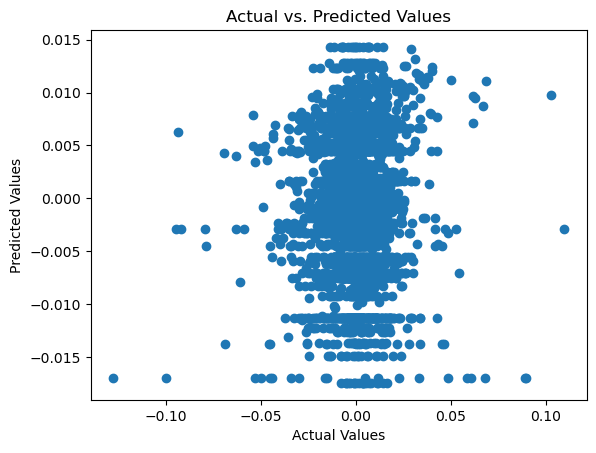

Mean Absolute Error: 0.008954943451521072
Mean Squared Error: 0.0001697252417485487
Root Mean Squared Error: 0.013027864051660528
R-squared: -0.17724887805650225
Mean Absolute Percentage Error (MAPE): 12418881582.34407


In [211]:
# Visualize predictions vs. actual values
plt.scatter(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections'] )
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

mae = mean_absolute_error(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections'] )
mse = mean_squared_error(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections'] )
rmse = np.sqrt(mse)
r2 = r2_score(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections'] )
mape = mean_absolute_percentage_error(sp500_d_includes_results['log_return'], sp500_d_includes_results['Predections'] )

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)

#print("Mean Absolute Error:", dfModelScore.loc[best_model_index, 'MAE'])
#print("Mean Squared Error:", dfModelScore.loc[best_model_index, 'MSE'])
#print("Root Mean Squared Error:", dfModelScore.loc[best_model_index, 'RMSE'])
#print("R-squared:", dfModelScore.loc[best_model_index, 'R2'])
#print("Mean Absolute Percentage Error (MAPE):", dfModelScore.loc[best_model_index, 'MAPE'])

In [212]:
# Assuming df is your DataFrame containing the data
# Replace 'feature1' and 'feature2' with the names of the features you want to plot
feature1 = 'log_return'
feature2 = 'Predections'

# Create line plot
fig = go.Figure(data=go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature1],
    mode='lines',
    name=feature1
))

# Add another line plot for the second feature
fig.add_trace(go.Scatter(
    x=sp500_d_includes_results.index,  # Assuming the index represents x-axis values
    y=sp500_d_includes_results[feature2],
    mode='lines',
    name=feature2
))

# Customize layout
fig.update_layout(
    title='Model - log_return Vs. Predictions on train dataset - WF 200,20',
    xaxis=dict(title='X Axis'),  # Customize x-axis label
    yaxis=dict(title='Y Axis'),  # Customize y-axis label
    hovermode='closest'
)

# Show plot
fig.show()